# Import libs

In [1]:
import os
import numpy as np
from tqdm import tqdm
from datetime import datetime
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# torch libs
import torch
import torch.nn as nn
import torch.nn.functional as F

from PIL import Image
from torchvision import datasets, transforms
import pickle
# custom libs
import utils, dataset_utils, settings
from IPython.display import clear_output

device_id = 0
torch.cuda.set_device(device_id)
device = 'cuda:{}'.format(device_id)
checkpoint_root = os.path.join(settings.PATH, 'models')

# Load data & model

In [2]:
dataset_name = 'svhn'
model_name = 'mobilenet'

dataset = dataset_utils.load_dataset(dataset_name)(
            batch_size=1024, doNormalization=True, 
            inj_rate=0.01)






SVHN::init - doNormalization is True


# Load model

In [3]:
path_dict = {'resnet56':{
                'cifar10': 'copy1/copy4/retrain_sdn_5.pt',
                'svhn': 'copy1/copy5/retrain_sdn_5.pt',
                'gtsrb': 'copy1/copy5/retrain_sdn_5.pt'},
            'vgg16':{
                'cifar10': 'copy1/copy5/retrain_sdn_5.pt',
                'svhn': 'copy1/copy5/retrain_sdn_5.pt',
                'gtsrb': 'copy1/copy5/retrain_sdn_5.pt'},
            'mobilenet':{
                'cifar10': 'copy1/copy2/retrain_sdn_5.pt',
                'svhn': 'copy1/copy5/retrain_sdn_5.pt',
                'gtsrb': 'copy1/copy3/retrain_sdn_5.pt'}}

In [ ]:
param_dict = {'resnet56':{
                'cifar10': (,),
                'svhn': (,),
                'gtsrb': (,)},
            'vgg16':{
                'cifar10': (,),
                'svhn': (,),
                'gtsrb': (,)},
            'mobilenet':{
                'cifar10': (,),
                'svhn': (,),
                'gtsrb': (,)}}

In [4]:

pretrained_sdn = os.path.join('{}_{}'.format(model_name, dataset_name), path_dict[model_name][dataset_name])
sdn_model_br = utils.get_sdn_model(model_name,
    utils.get_add_output(model_name), 
    dataset.num_classes, 
    dataset.img_size
)
sdn_model_br.load_state_dict(torch.load(os.path.join(checkpoint_root, pretrained_sdn), map_location=device))
sdn_model_br.eval()
sdn_model_br.to(device)
print("Loaded")

Loaded


# Test Threshold

In [6]:
output_list = []
with torch.no_grad():
    out_idxs = []
    for x, y in dataset.test_backdoor_loader:
        x = x.to(device)
        output = sdn_model_br(x)
        output_list.append(torch.stack(output))
output_list = torch.cat(output_list, dim=1)
output_list = list(output_list)
num_exits = len(output_list)

In [11]:
np.linspace(0.8,0.98, 10)

array([0.8 , 0.82, 0.84, 0.86, 0.88, 0.9 , 0.92, 0.94, 0.96, 0.98])

In [12]:
th_range = np.linspace(0.8,0.98, 10)
start_range = list(range(num_exits))
result_array = np.zeros((num_exits, len(th_range)))
for i, th in enumerate(th_range):
    for j, start in enumerate(start_range):
        
        b_out_idx, b_pred = utils.test_threshold(output_list, th, start_from_include=start)
        result_array[j][i] = torch.sum(b_pred == dataset.target_class) / len(b_pred)

In [15]:
print("\t", end="")
for col_id, th in enumerate(th_range):
    print("{:.2f}".format, end="\t")
print()
for row_id, start in enumerate(start_range):
    print(row_id, end="\t")
    for col_id, th in enumerate(th_range):
        print("{:.2f}".format(result_array[j][i] * 100), end="\t")
    print()

	0.8	0.8200000000000001	0.8400000000000001	0.86	0.88	0.9	0.92	0.94	0.96	0.98	
0	0.07	0.07	0.07	0.07	0.07	0.07	0.07	0.07	0.07	0.07	
1	0.07	0.07	0.07	0.07	0.07	0.07	0.07	0.07	0.07	0.07	
2	0.07	0.07	0.07	0.07	0.07	0.07	0.07	0.07	0.07	0.07	
3	0.07	0.07	0.07	0.07	0.07	0.07	0.07	0.07	0.07	0.07	
4	0.07	0.07	0.07	0.07	0.07	0.07	0.07	0.07	0.07	0.07	
5	0.07	0.07	0.07	0.07	0.07	0.07	0.07	0.07	0.07	0.07	
6	0.07	0.07	0.07	0.07	0.07	0.07	0.07	0.07	0.07	0.07	
7	0.07	0.07	0.07	0.07	0.07	0.07	0.07	0.07	0.07	0.07	
8	0.07	0.07	0.07	0.07	0.07	0.07	0.07	0.07	0.07	0.07	
9	0.07	0.07	0.07	0.07	0.07	0.07	0.07	0.07	0.07	0.07	
10	0.07	0.07	0.07	0.07	0.07	0.07	0.07	0.07	0.07	0.07	
11	0.07	0.07	0.07	0.07	0.07	0.07	0.07	0.07	0.07	0.07	
12	0.07	0.07	0.07	0.07	0.07	0.07	0.07	0.07	0.07	0.07	
13	0.07	0.07	0.07	0.07	0.07	0.07	0.07	0.07	0.07	0.07	


In [ ]:
dataset.target

In [ ]:
param_dict = {'resnet56':{
                'cifar10': (0.9, 6),
                'svhn': (0.9, 6),
                'gtsrb': (0.9, 6)},
            'vgg16':{
                'cifar10': (0.9, 6),
                'svhn': (0.9, 6),
                'gtsrb': (0.9, 6)}}

# NC_results

In [1]:
NC_index_dict = {
    'resnet56':{
                'cifar10': [0.7547265, 0.7740901, 1.0319731, 0.6744908, 0.67449075],
                'svhn': [0.80203646, 0.6875345, 0.7823384, 0.8611542, 0.84772307],
                'gtsrb': [1.6401646, 1.4097111, 1.8257439, 1.4505603, 1.7043517]},
    'vgg16':{
        'cifar10': [1.0637802, 1.3048444, 1.310615, 1.1991191, 1.1427827],
        'svhn': [0.7274478, 0.8199793, 0.69237834, 0.7406014, 0.89448583],
        'gtsrb': [1.9987018, 1.9689213, 1.8621215, 1.9854466, 1.9760653]}
}

# Plot

In [20]:
cifar10 = dataset_utils.load_dataset('cifar10')(
            batch_size=1024, doNormalization=True, 
            inj_rate=0.01)
svhn = dataset_utils.load_dataset('svhn')(
            batch_size=1024, doNormalization=True, 
            inj_rate=0.01)
gtsrb = dataset_utils.load_dataset('gtsrb')(
            batch_size=1024, doNormalization=True, 
            inj_rate=0.01)

CIFAR10::init - doNormalization is True
SVHN::init - doNormalization is True
GTSRB::init - doNormalization is True


In [21]:
topil = transforms.ToPILImage()

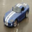

In [22]:
topil(cifar10.train.data[cifar10.inj_idx[0]])

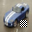

In [70]:

fig, axes = plt.subplots(2, 3)

axes[0][0].imshow(topil(cifar10.train.data[cifar10.inj_idx[0]]))
axes[1][0].imshow(topil(cifar10.train_backdoor.data[cifar10.inj_idx[0]]))
axes[0][0].axis('off')
axes[1][0].axis('off')
axes[0][0].set_title("CIFAR-10")
axes[0][0].annotate("Clean", xy=(0, 0), xytext=(-6, 20), rotation=90, fontsize=18)
axes[1][0].annotate("Poisoned", xy=(0, 0), xytext=(-6, 24), rotation=90, fontsize=18)

axes[0][1].imshow(topil(svhn.train.data[svhn.inj_idx[3]]))
axes[1][1].imshow(topil(svhn.train_backdoor.data[svhn.inj_idx[3]]))
axes[0][1].axis('off')
axes[1][1].axis('off')
axes[0][1].set_title("SVHN")

axes[0][2].imshow(topil(gtsrb.train.data[gtsrb.inj_idx[55]]))
axes[1][2].imshow(topil(gtsrb.train_backdoor.data[gtsrb.inj_idx[55]]))
axes[0][2].axis('off')
axes[1][2].axis('off')
axes[0][2].set_title("GTSRB")

fig.tight_layout()
plt.savefig("example.pdf", bbox_inches='tight')
